FMNIST Classifier:This notebook uses preloaded keras FMNIST dataset and implenting Convolutional Neural Networks to train and test the models.
Also Utilizing pre-trained VGG-19 CNN model

Importing Libraries

In [1]:
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping
import pandas as pd

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import cv2
import json
import requests
from tqdm import tqdm


print(tf.__version__)

2.8.2


Loading Dataset

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\nTrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('Test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

4431872/4422102 [==============================] - 0s 0us/step

Train_images.shape: (60000, 28, 28), of uint8
Test_images.shape: (10000, 28, 28), of uint8


Reshaping Image Data for Modeling

In [3]:
# reshape for feeding into the model
train_images_gr = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images_gr = test_images.reshape(test_images.shape[0], 28, 28, 1)

print('\nTrain_images.shape: {}, of {}'.format(train_images_gr.shape, train_images_gr.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_gr.shape, test_images_gr.dtype))


Train_images.shape: (60000, 28, 28, 1), of uint8
Test_images.shape: (10000, 28, 28, 1), of uint8


Plotting some of the figures from train dataset

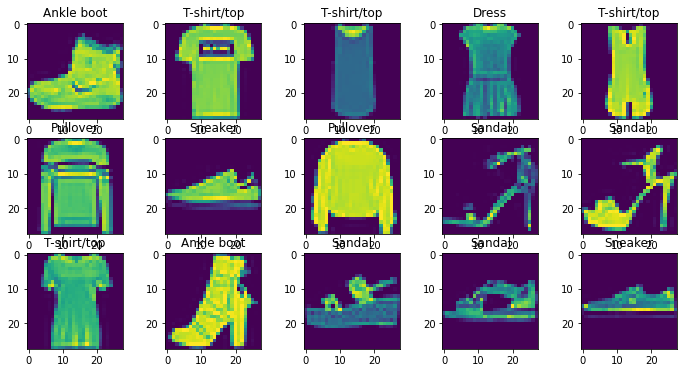

In [4]:
fig, ax = plt.subplots(3, 5, figsize=(12, 6))
c = 0
for i in range(15):
 idx = i // 5
 idy = i % 5
 ax[idx, idy].imshow(train_images_gr[i].reshape(28,28))
 ax[idx, idy].set_title(class_names[train_labels[i]])

Building CNN Model Architecture

In [5]:
# define input shape
INPUT_SHAPE = (28, 28, 1)

# define sequential model
model = tf.keras.models.Sequential()
# define conv-pool layers - set 1
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1),
activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# define conv-pool layers - set 2
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1),
activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# compile model
model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

# view model layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 256)               2

Model Training

In [6]:
EPOCHS = 100
train_images_scaled = train_images_gr / 255.
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,
restore_best_weights=True,
verbose=1)

history = model.fit(train_images_scaled, train_labels,
batch_size=32,
callbacks=[es_callback],
validation_split=0.1, epochs=EPOCHS,
verbose=1)

Epoch 1/100
1688/1688 [==============================] - 20s 4ms/step - loss: 0.5435 - accuracy: 0.7988 - val_loss: 0.3708 - val_accuracy: 0.8700
Epoch 2/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3498 - accuracy: 0.8725 - val_loss: 0.2922 - val_accuracy: 0.8897
Epoch 3/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3022 - accuracy: 0.8892 - val_loss: 0.2926 - val_accuracy: 0.8928
Epoch 4/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2718 - accuracy: 0.9001 - val_loss: 0.2788 - val_accuracy: 0.8957
Epoch 5/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2490 - accuracy: 0.9072 - val_loss: 0.2624 - val_accuracy: 0.9070
Epoch 6/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2327 - accuracy: 0.9145 - val_loss: 0.2442 - val_accuracy: 0.9050
Epoch 7/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2179 - accuracy: 0.9182 - val_loss: 0.2553 - val_a

Ploting Learning Curves

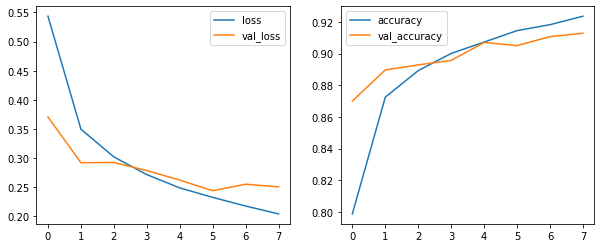

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

Evaluating Model Performance on Test Data

In [8]:
test_images_scaled = test_images_gr / 255.
predictions = model.predict(test_images_scaled)
predictions[:5]

array([[2.3279384e-08, 1.6647057e-08, 5.6776805e-08, 3.7409595e-09,
        5.4717417e-09, 1.5216933e-04, 3.2838088e-08, 4.3358767e-04,
        8.0269665e-08, 9.9941397e-01],
       [1.6991121e-06, 3.8547016e-14, 9.9995077e-01, 2.1286397e-09,
        1.2812953e-06, 7.7830842e-15, 4.6311852e-05, 1.4221549e-15,
        2.6814896e-11, 2.9862015e-15],
       [1.3975439e-16, 1.0000000e+00, 4.5219185e-18, 1.6134057e-16,
        1.8783783e-16, 1.5980470e-19, 2.3768396e-16, 8.9855083e-24,
        4.9019844e-18, 9.9991687e-22],
       [3.0905554e-12, 1.0000000e+00, 5.3867891e-13, 5.1218463e-10,
        2.1571667e-10, 2.2242757e-14, 2.6031058e-11, 8.7927724e-17,
        8.2821445e-14, 2.8718883e-15],
       [3.4181854e-01, 2.2509159e-06, 2.6247548e-02, 1.5749896e-03,
        1.4558267e-03, 3.3740255e-07, 6.2887937e-01, 3.6608270e-08,
        2.1096261e-05, 5.8159625e-08]], dtype=float32)

In [9]:
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]

array([9, 2, 1, 1, 6])

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.87      0.86      1000
     Trouser       1.00      0.97      0.99      1000
    Pullover       0.85      0.86      0.86      1000
       Dress       0.88      0.94      0.91      1000
        Coat       0.89      0.76      0.82      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.70      0.73      0.71      1000
     Sneaker       0.97      0.91      0.94      1000
         Bag       0.97      0.98      0.98      1000
  Ankle boot       0.92      0.98      0.95      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,873,0,18,25,2,2,70,0,10,0
Trouser,0,974,0,16,2,0,6,0,2,0
Pullover,10,0,861,8,40,0,81,0,0,0
Dress,11,0,10,937,7,0,31,0,4,0
Coat,2,0,68,47,757,0,126,0,0,0
Sandal,0,0,0,0,0,981,0,12,1,6
Shirt,134,1,52,28,43,0,730,0,12,0
Sneaker,0,0,0,0,0,12,0,906,0,82
Bag,3,0,4,3,1,3,0,2,984,0
Ankle boot,1,0,0,0,0,5,0,11,0,983


In [11]:
print(test_labels[:100])
test_labels
test_image_idxs = [0, 23, 28]
test_labels[test_image_idxs]

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2]


array([9, 9, 9], dtype=uint8)

In [12]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

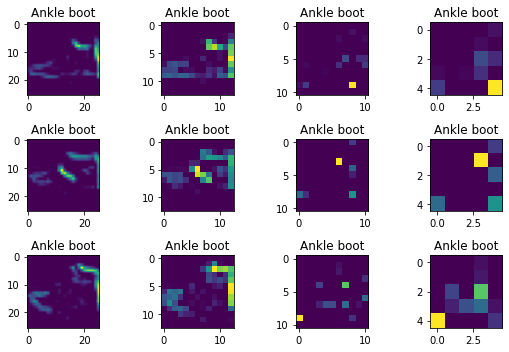

In [13]:
f, axarr = plt.subplots(3,4, figsize=(8, 5))

FIRST_IMAGE=0
SECOND_IMAGE=23
THIRD_IMAGE=28
CONVOLUTION_NUMBER = 13

for x in range(0,4):
 f1 = activation_model.predict(test_images_scaled[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
 axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER])
 axarr[0,x].grid(False)
 axarr[0,x].set_title(class_names[test_labels[FIRST_IMAGE]])
 f2 = activation_model.predict(test_images_scaled[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
 axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER])
 axarr[1,x].grid(False)
 axarr[1,x].set_title(class_names[test_labels[SECOND_IMAGE]])
 f3 = activation_model.predict(test_images_scaled[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
 axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER])
 axarr[2,x].grid(False)
 axarr[2,x].set_title(class_names[test_labels[THIRD_IMAGE]])
 plt.tight_layout()

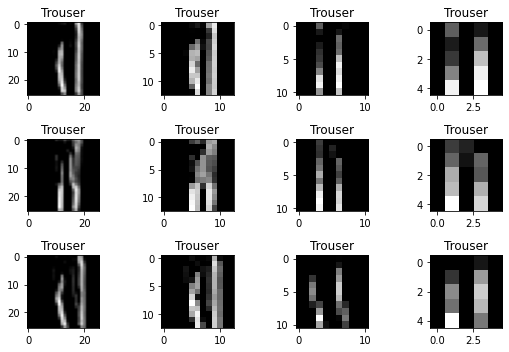

In [14]:
f, axarr = plt.subplots(3,4, figsize=(8, 5))

FIRST_IMAGE=2
SECOND_IMAGE=3
THIRD_IMAGE=5
CONVOLUTION_NUMBER = 13

for x in range(0,4):
 f1 = activation_model.predict(test_images_scaled[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
 axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
 axarr[0,x].grid(False)
 axarr[0,x].set_title(class_names[test_labels[FIRST_IMAGE]])
 f2 = activation_model.predict(test_images_scaled[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
 axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
 axarr[1,x].grid(False)
 axarr[1,x].set_title(class_names[test_labels[SECOND_IMAGE]])
 f3 = activation_model.predict(test_images_scaled[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
 axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
 axarr[2,x].grid(False)
 axarr[2,x].set_title(class_names[test_labels[THIRD_IMAGE]])
 plt.tight_layout()

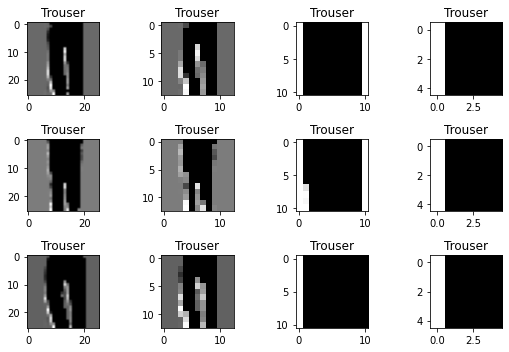

In [15]:
f, axarr = plt.subplots(3,4, figsize=(8, 5))

FIRST_IMAGE=2
SECOND_IMAGE=3
THIRD_IMAGE=5
CONVOLUTION_NUMBER = 3

for x in range(0,4):
 f1 = activation_model.predict(test_images_scaled[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
 axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
 axarr[0,x].grid(False)
 axarr[0,x].set_title(class_names[test_labels[FIRST_IMAGE]])
 f2 = activation_model.predict(test_images_scaled[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
 axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
 axarr[1,x].grid(False)
 axarr[1,x].set_title(class_names[test_labels[SECOND_IMAGE]])
 f3 = activation_model.predict(test_images_scaled[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
 axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
 axarr[2,x].grid(False)
 axarr[2,x].set_title(class_names[test_labels[THIRD_IMAGE]])
 plt.tight_layout()

Fine-tuning a pre-trained VGG-19 CNN Model

Reshaping Image Data for Modeling

In [16]:
train_images_3ch = np.stack([train_images]*3, axis=-1)
test_images_3ch = np.stack([test_images]*3, axis=-1)

print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))


Train_images.shape: (60000, 28, 28, 3), of uint8
Test_images.shape: (10000, 28, 28, 3), of uint8


Resizing Image Data for Modeling

In [17]:
import cv2

def resize_image_array(img, img_size_dims):
 img = cv2.resize(img, dsize=img_size_dims,
 interpolation=cv2.INTER_CUBIC)
 img = np.array(img, dtype=np.float32)
 return img

In [18]:
%%time

IMG_DIMS = (32, 32)

train_images_3ch = np.array([resize_image_array(img, img_size_dims=IMG_DIMS) for img in train_images_3ch])
test_images_3ch = np.array([resize_image_array(img, img_size_dims=IMG_DIMS) for img in test_images_3ch])

print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))


Train_images.shape: (60000, 32, 32, 3), of float32
Test_images.shape: (10000, 32, 32, 3), of float32
CPU times: user 1.55 s, sys: 657 ms, total: 2.2 s
Wall time: 2.26 s


Building our CNN model architecture customizing the VGG-19 model.

In [19]:
# define input shape
INPUT_SHAPE = (32, 32, 3)

# get the VGG19 model
vgg_layers = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False,
input_shape=INPUT_SHAPE)

vgg_layers.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

Set layers to trainable to enable fine-tuning

In [20]:
# Fine-tune all the layers
for layer in vgg_layers.layers:
 layer.trainable = True

# Check the trainable status of the individual layers
for layer in vgg_layers.layers:
 print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa952296450> True
<keras.layers.convolutional.Conv2D object at 0x7fa9f955f310> True
<keras.layers.convolutional.Conv2D object at 0x7fa95136de90> True
<keras.layers.pooling.MaxPooling2D object at 0x7fa95128dfd0> True
<keras.layers.convolutional.Conv2D object at 0x7fa9512aba10> True
<keras.layers.convolutional.Conv2D object at 0x7fa951308650> True
<keras.layers.pooling.MaxPooling2D object at 0x7fa9525c0b90> True
<keras.layers.convolutional.Conv2D object at 0x7fa9511d8690> True
<keras.layers.convolutional.Conv2D object at 0x7fa9511c8c50> True
<keras.layers.convolutional.Conv2D object at 0x7fa95130d610> True
<keras.layers.convolutional.Conv2D object at 0x7fa951a0bb10> True
<keras.layers.pooling.MaxPooling2D object at 0x7fa951348f50> True
<keras.layers.convolutional.Conv2D object at 0x7fa9512369d0> True
<keras.layers.convolutional.Conv2D object at 0x7fa951221c10> True
<keras.layers.convolutional.Conv2D object at 0x7fa95133f890> True
<keras.l

Building CNN model on top of VGG19

In [21]:
# define sequential model
model = tf.keras.models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_layers)

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

# view model layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 10)               

In [27]:
EPOCHS = 100
train_images_3ch_scaled = train_images_3ch / 255.
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,
restore_best_weights=True,
verbose=1)

history = model.fit(train_images_3ch_scaled, train_labels,
batch_size=32,
callbacks=[es_callback],
validation_split=0.1, epochs=EPOCHS,
verbose=1)

Epoch 1/100
1688/1688 [==============================] - 69s 41ms/step - loss: 0.1792 - accuracy: 0.9384 - val_loss: 0.2030 - val_accuracy: 0.9298
Epoch 2/100
1688/1688 [==============================] - 65s 39ms/step - loss: 0.1582 - accuracy: 0.9444 - val_loss: 0.2067 - val_accuracy: 0.9298
Epoch 3/100
1688/1688 [==============================] - 65s 39ms/step - loss: 0.1418 - accuracy: 0.9502 - val_loss: 0.2116 - val_accuracy: 0.9287
Epoch 3: early stopping


Evaluating Model Performance on Test Data

In [ ]:
test_images_3ch_scaled = test_images_3ch / 255.
predictions = model.predict(test_images_3ch_scaled)
predictions[:5]

In [25]:
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]

array([9, 2, 1, 1, 6])

In [26]:
print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.90      0.88      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.87      0.90      0.89      1000
       Dress       0.92      0.91      0.91      1000
        Coat       0.87      0.88      0.87      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.81      0.73      0.77      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.98      0.99      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,896,0,18,19,1,0,56,0,10,0
Trouser,0,985,0,9,2,0,2,0,2,0
Pullover,7,2,903,9,33,0,45,0,1,0
Dress,11,8,9,911,33,0,27,0,1,0
Coat,1,0,56,18,879,0,44,0,2,0
Sandal,0,0,0,0,0,988,0,12,0,0
Shirt,125,1,46,26,65,0,731,0,6,0
Sneaker,0,0,0,0,0,4,0,980,0,16
Bag,1,0,1,1,1,1,0,0,995,0
Ankle boot,0,0,0,0,0,8,1,31,0,960


              precision    recall  f1-score   support

 T-shirt/top       0.86      0.90      0.88      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.87      0.90      0.89      1000
       Dress       0.92      0.91      0.91      1000
        Coat       0.87      0.88      0.87      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.81      0.73      0.77      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.98      0.99      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,896,0,18,19,1,0,56,0,10,0
Trouser,0,985,0,9,2,0,2,0,2,0
Pullover,7,2,903,9,33,0,45,0,1,0
Dress,11,8,9,911,33,0,27,0,1,0
Coat,1,0,56,18,879,0,44,0,2,0
Sandal,0,0,0,0,0,988,0,12,0,0
Shirt,125,1,46,26,65,0,731,0,6,0
Sneaker,0,0,0,0,0,4,0,980,0,16
Bag,1,0,1,1,1,1,0,0,995,0
Ankle boot,0,0,0,0,0,8,1,31,0,960
